In [1]:
import events
import settings
import metrics
import plotting

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from scipy import sparse
import pandas as pd
import pprint

import networkx as nx
import os
import itertools

In [4]:
logname = 20220929214507
log = f"..//logs//{logname}"

configs = settings.load(f"{log}//settings.log")
stats = metrics.load(f"{log}//metrics.log")

In [5]:
events.analyze(
    f"{log}//events",
    counter := events.EventCallback(events.EventCounterData),
    updates := events.EventCallback(events.UpdatesData),
    timeline := events.EventCallback(events.TimelineData),
    reachability := events.EventCallback(events.ReachabilityData),
    received := events.EventCallback(events.ReceivedData))

  0%|          | 0.00/29.6G [00:00<?, ?it/s]

In [6]:
coeffs = np.array([config.msg.send_coeff for config in configs])
num_updates = np.array([update.num_updated for update in updates])

In [7]:
groups = np.array([num_updates[coeffs == c] for c in np.unique(coeffs)])

In [8]:
normal_groups = groups.T / np.expand_dims(groups.max(axis=0), axis=1)

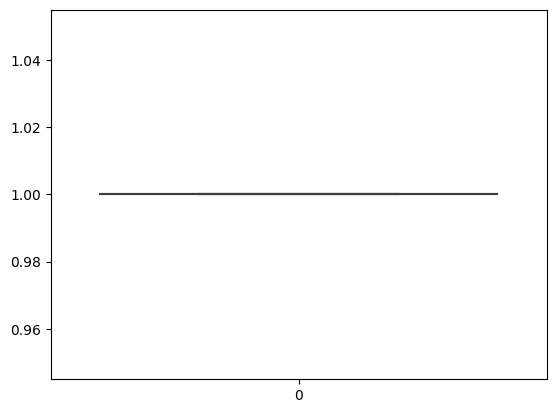

In [9]:
sns.boxplot(normal_groups);

In [10]:
sns.histplot(updates[3].updates, discrete=True);

IndexError: list index out of range

In [9]:
def updates_hist_plot(data: events.UpdatesData) -> None:
    opts = {"binwidth": 0.01, "stat": "density"}
    sns.histplot([data.symptoms, data.exposures], **opts)
    plt.legend(["Symptom score", "Exposure score"])
    plt.xlabel("Risk score")

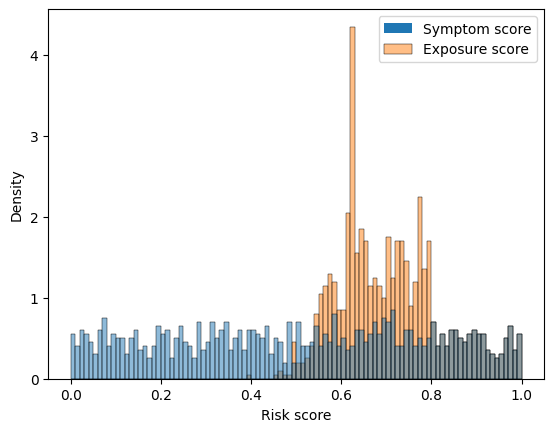

In [13]:
updates_hist_plot(updates[3])

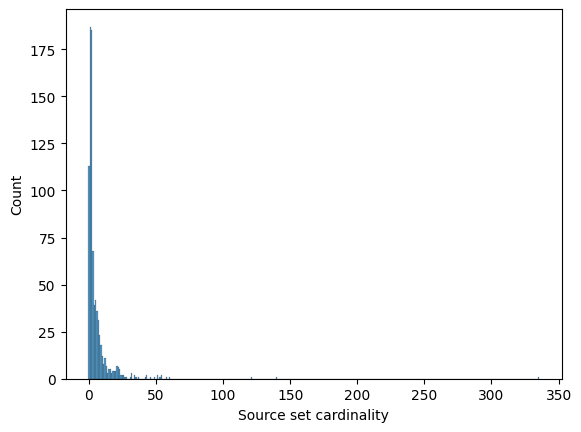

In [17]:
sns.histplot(reachability[3].source_size(), discrete=True)
plt.xlabel("Source set cardinality");

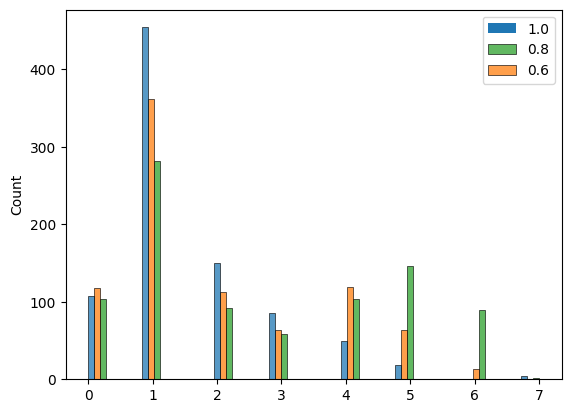

In [234]:
legend = [config.msg.send_coeff for config in reversed(configs[:3])]
data = [data.msg_reach() for data in reversed(reachability[:3])]
sns.histplot(data, multiple="dodge");
plt.legend(legend);

In [36]:
iteration = 15
x_axis = "time"

positions, n_events = plotting.event_plot_positions(timeline[iteration], x_axis=x_axis)
start = positions[2][0]  # First contact msg
end = positions[0][-1]  # Last recevied msg
print(runtime := end - start)

0.016


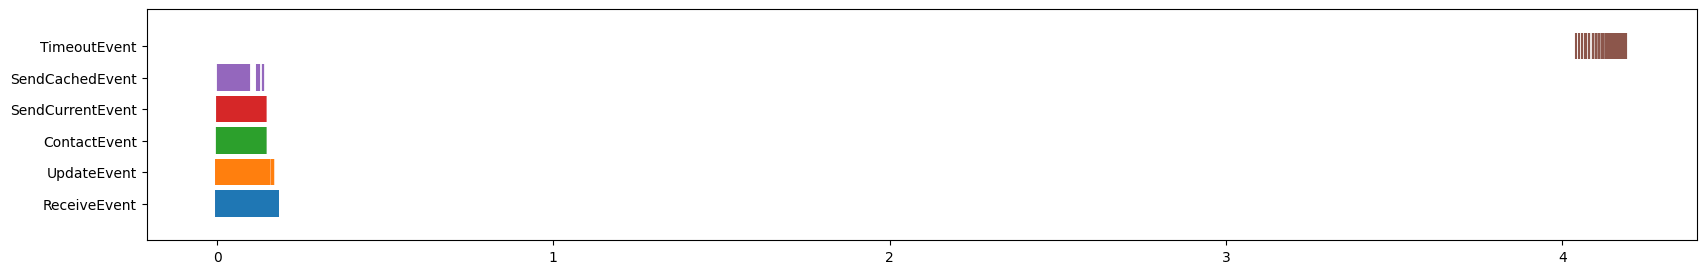

In [22]:
line_len = 5
fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(111)
offsets = np.arange(n_events) * (line_len + 1)
ax.axes.set_yticks(offsets)
ax.axes.set_yticklabels(timeline[0].i2e)
ax.eventplot(
    positions,
    colors=[f"C{i}" for i in range(n_events)],
    linelengths=np.repeat(line_len, n_events),
    lineoffsets=np.arange(n_events) * (line_len + 1), 
);

In [41]:
graph = nx.from_scipy_sparse_array(reachability[0].adj)
plt.figure(dpi=200)
nx.draw(
    graph,
    pos=nx.spring_layout(graph),
    width=0.1,
    with_labels=False,
    node_size=10)

NetworkXError: Adjacency matrix not square: nx,ny=(875, 1000)